# Preparação dos Dados

In [14]:
from datetime import datetime
from time import time
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import h5py

# Módulo do software da implementação do MOD17
import mod17
from mod17 import MOD17, PFT_VALID
from mod17.utils import restore_bplut, pft_remap


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.constraints.as_penalty import ConstraintsAsPenalty
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import SBX
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output
from IPython.display import display, HTML
from typing import List, Union


sns.set_style('darkgrid')
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))
    

def reg_graph_subplot(x, y, data, sct_size=None, s=10, title='', legend_visibility=True, legend_title='', xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False, offset_txt_x=0.15, offset_txt_y=2.25, reg_from_start=True, axes=None):
    # Configurações do estilo do gráfico
    sns.set_style('darkgrid')
    
    # Criar figura e eixos
    f, ax = plt.subplots(figsize=(12, 5))

    # Scatter plot
    sns.scatterplot(x=data[x], y=data[y], data=data, size=sct_size, s=s, ax=ax)

    # Inicializar modelo de regressão linear
    lr = LinearRegression(fit_intercept=fit_intercept)
    
    fitted_reg = lr.fit(data[[x]], data[[y]])

    # Calcular R² Score
    r2_score = fitted_reg.score(data[[x]], data[[y]])

    # Gerar pontos para a linha de regressão
    x_reg_line = np.linspace(data[x].min(), data[x].max(), 100)
    intercept = round(fitted_reg.intercept_[0], 4) if fit_intercept else 0
    
    if fit_intercept:
        y_reg_line = lr.predict(x_reg_line.reshape(-1, 1))
    else:
        y_reg_line = x_reg_line * fitted_reg.coef_[0][0]  # Calcula os valores de y manualmente para que a linha passe pela origem

    if reg_from_start:
        if (data[x].min() < 0) and (abs(data[x].min()) > data[y].max()):  # Para valores data[x] negativos
            x_reg_line = np.linspace(data[x].min() * 2, 0.0, 100)  # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0
        elif (data[y].min() < 0) and (abs(data[y].min()) > data[x].max()):  # Para valores data[y] negativos
            x_reg_line = np.linspace(data[y].min() * 2, 0.0, 100)  # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0
        elif (data[x].max() > data[y].max()):
            x_reg_line = np.linspace(0.0, data[x].max() * 2, 100)
        else:
            x_reg_line = np.linspace(0.0, data[y].max() * 2, 100)

        if fit_intercept:
            y_reg_line = lr.predict(x_reg_line.reshape(-1, 1))
        else:
            y_reg_line = x_reg_line * fitted_reg.coef_[0][0]  # Calcula os valores de y manualmente para que a linha passe pela origem

    # Plotar linha de regressão
    ax.plot(x_reg_line, y_reg_line, color='blue')

    # Plotar linha de referência y=x
    if ativar_grafico_yx:
        ax.plot([0, 1], [0, 1], 'k--', transform=ax.transAxes)  # Adicionando a linha y=x

    # Texto da equação da regressão e R²
    text_coord_x = data[x].max() + offset_txt_x
    
    ax.text(text_coord_x, offset_txt_y, f'Y={round(fitted_reg.coef_[0][0], 4)}x + {intercept}',
            fontsize=12, ha='center', va='center', color='blue')
    ax.text(text_coord_x, offset_txt_y - (offset_txt_y * 0.2), f'R²: {round(r2_score, 4)}', fontsize=12, ha='center',
            va='center', color='blue')
    ax.text(text_coord_x, offset_txt_y - (offset_txt_y * 0.4), f'Corr: {round(pearsonr(data[x],data[y])[0],4)}', fontsize=12, ha='center',
            va='center', color='blue')
    
    # Limites dos eixos
    ax.set_ylim((0, (data[y].max() + (data[y].max() / 2))))  # tamanho limite do plot no eixo y
    ax.set_xlim((0, data[x].max() + data[x].max() / 2))  # tamanho limite do plot no eixo x

    # Legenda
    if legend_visibility:
        ax.legend(title=legend_title, loc='upper left').set_visible(True)
    else:
        ax.legend().set_visible(False)

    # Títulos e rótulos dos eixos
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    return ax


def Reco_Horario(serie_reco:pd.Series) -> float:   
    return serie_reco.between_time('20:00', '06:00').sum()

def Gpp_Horario(serie_gpp: pd.Series) -> float:   
    return serie_gpp.between_time('07:00', '19:00').sum()

def create_flux_data(dataframe: pd.DataFrame, var: List[Union[str, str]],kg_c = True) -> pd.DataFrame:
    """
    Cria um DataFrame com os dados de fluxo de carbono de acordo com a variável alvo especificada.
    
    Args:
        data_df (pd.DataFrame): DataFrame que conterá os dados de fluxo de carbono.
        dataframe (pd.DataFrame): DataFrame contendo os dados originais.
        var (List[str, str]): Lista contendo o nome da variável alvo e sua respectiva coluna nos dados originais.
        
    Returns:
        pd.DataFrame: DataFrame contendo os dados de fluxo de carbono atualizados.
    """
    # Mapeamento das funções para calcular as variáveis alvo
    var_names = {
        'gpp': Gpp_Horario,
        'reco': Reco_Horario
        # Adicione aqui outras variáveis alvo, se necessário
    }
    
    data_df = pd.DataFrame(index=np.unique(dataframe.index.date)) # index = datas do dataframe (DADOS NÃO SÃO PUXADOS)
    
    data_df[f'{var[0]}'] = pd.Series(dtype='float') # Cria uma coluna com o nome da variável alvo
    
    for date in data_df.index:
        """
        Loop através de cada data para calcular os valores desejados.
        """
        # Obtendo a data no formato YYYY/MM/DD
        
        date_str = date.strftime("%Y-%m-%d")
        
        # Obtendo o valor da variável alvo do dataframe original
        var_alvo = dataframe[var[1]].loc[date_str]
        
        # Chamando a função apropriada para calcular a variável alvo
        var_alvo = var_names.get(var[0].lower())(var_alvo)
        
        # Atualizando o DataFrame com o valor calculado
        data_df.loc[date, var[0]] = var_alvo
    
    # Aplicando transformação para kgC
    if kg_c:
        data_df[var[0]] = data_df[var[0]].apply(to_kgC)
    data_df.index = data_df.reset_index()['index'].apply(lambda x:pd.to_datetime(x))
    
    return data_df

def to_kgC(x):
    """Retorna valores convertidos para kg C m² s"""
    umol2mol = 1e-06
    Cmol = 0.012011
    minutesinseconds = 1800
    #days2seconds = 86400
    kg2g = 1000 # Precisamos em kg, não em g, por isso não multipliquei por 1000
    
    return x * umol2mol * Cmol * minutesinseconds # cálculo dado pelo professor



# ======= Preparação dos dados originais da torre de fluxo do Peru =================================================================
# am_peru_h = pd.read_csv('amf_pe/AMF_PE-QFR_FLUXNET_FULLSET_HH_2018-2019_3-5.csv',na_values=-9999) # Dados da torre pro mesmo dia
# am_peru_h.index = am_peru_h['TIMESTAMP_START'].apply(lambda x:datetime.strptime(str(x), '%Y%m%d%H%M%S'))
# gpp_peru_h = am_peru_h['GPP_DT_VUT_REF']['2018':'2019'].copy() # Gpp da torre em Hora
# gpp_peru_h.to_csv('AMF_PE-QFR_FLUXNET_FULLSET_HH_2018-2019_3-5.csv') # Transformar para csv apenas com o GPP a fim de reduzir o tamanho original do arquivo


# ======= Preparação dos dados originais da torre de fluxo de Santarem =================================================================
# am_santarem_h = pd.read_csv('./santarem_torre/ameriflux-santarem-dados-original.csv',na_values=-9999.0) # Dados da AMERIFLUX
# am_santarem_h.loc[0, 'Time'] = '00:00:00'
# am_santarem_h.index = pd.to_datetime(am_santarem_h['Date'] + ' ' + am_santarem_h['Time'], format='%Y-%m-%d %H:%M:%S')
# am_santarem_h[['Reco_uStar', 'GPP_uStar_f','NEE_uStar_f']]
# am_santarem_h.to_csv('./santarem_torre/ameriflux-santarem-dados-original.csv') # Transformar para csv apenas com o GPP a fim de reduzir o tamanho original do arquivo



gpp_peru_h = pd.read_csv('amf_pe/AMF_PE-QFR_FLUXNET_FULLSET_HH_2018-2019_3-5.csv')
gpp_peru_h.index = gpp_peru_h['TIMESTAMP_START'].apply(lambda x:datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))
gpp_peru_h = gpp_peru_h['GPP_DT_VUT_REF']['2018':'2019']

gpp_peru_g = create_flux_data(gpp_peru_h.to_frame(),['Gpp','GPP_DT_VUT_REF']) * 1000

am_peru_D = pd.read_csv('amf_pe/AMF_PE-QFR_FLUXNET_FULLSET_DD_2018-2019_3-5.csv',na_values=-9999) # Dados da torre pro mesmo dia
am_peru_D.index = am_peru_D['TIMESTAMP'].apply(lambda x:datetime.strptime(str(x), '%Y%m%d'))

gpp = pd.read_csv('./santarem_torre/ameriflux-santarem-dados-original.csv').rename(columns={'Unnamed: 0':'TIMESTAMP_START'})
gpp.index = gpp['TIMESTAMP_START'].apply(lambda x:datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))
gpp = gpp['GPP_uStar_f']

gpp_santarem_gc = create_flux_data(gpp.to_frame(),['Gpp','GPP_uStar_f']) * 1000

smoothed_gpp_peru_torre = ExponentialSmoothing(gpp_peru_g, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues
smoothed_gpp_santarem_torre = ExponentialSmoothing(gpp_santarem_gc, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

## Cálculo do GPP com os Parâmetros da BPLUT (MERRA-2)

### Santarém

In [15]:
def constructor_2(path):
    """Função para construir os Dataframes dos dados metereológicos do MERRA-2"""
    nome = path.split('/')[1].split('_')[0]
    df = pd.read_csv(path, parse_dates=['date'])
    df = df.rename({'albedo':nome},axis=1)
    hora_inicio = df['date'].min().floor('d')
    df.index = hora_inicio + pd.to_timedelta(df.index, unit='h')
    df = df.drop(['date','.geo'], axis=1)
    df = df.drop('system:index',axis=1)
    return df


# Leitura e pré-processamento dos dados de temperatura
tday = constructor_2('merra_Santarem/T10M_SANTAREM_Time_Series.csv') - 273.15 #( K° -> C°)
tmin = tday['T10M'].resample('D').min().values  # Reamostrando para Temperatura mínima diária
tmean_santarem = tday['T10M'].resample('D').mean().values  # Temperatura média diária
tmean_vpd = tday['T10M'].between_time('9:00', '21:00').resample('D').mean().values
             
# Leitura e pré-processamento dos dados de razão de mistura de vapor de água
qv10m = constructor_2('merra_Santarem/QV10M_SANTAREM_Time_Series.csv') # unidade: "Mass fraction" (kg/kg)
qv10m = pd.to_numeric(qv10m['QV10M']).between_time('9:00', '21:00').resample('D').mean().values

# Leitura e pré-processamento dos dados de pressão atmosférica
ps = constructor_2('merra_Santarem/PS_SANTAREM_Time_Series.csv') # unidade: Pa  # Removendo vírgulas dos valores
ps['PS'] = pd.to_numeric(ps['PS'])
ps = ps.between_time('9:00', '21:00').resample('D').mean()
ps = pd.to_numeric(ps['PS']).values

# Leitura e pré-processamento dos dados de radiação solar incidente
SWGNT = constructor_2('merra_Santarem/SWGNT_SANTAREM_Time_Series.csv')['SWGNT'].resample('D').mean().values # unidade: W/m^2

# Função para converter datas no formato MODIS
def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data

# Leitura e pré-processamento dos dados de Fração de Absorção de Luz Fotossinteticamente Ativa (FPAR)
fpar = pd.read_csv('santarem_mod/filtered_scaled_Fpar_500m.csv', header=None,na_values='F') # unidade: (%)
fpar.index = fpar[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
fpar = fpar.drop([0,1,2,3,4], axis=1)
fpar.columns = range(len(fpar.columns))
fpar = fpar[144]

# ================================

# Tratamento de dados faltando usando interpolação linear (8 dias -> diário)
fpar = fpar.resample('D').interpolate('linear')['2009-01-01':'2011-12-31']
fpar = fpar.values

drivers_santarem = [
    fpar[:][...,None],
    tmin[:][...,None],
    MOD17.vpd(qv10m, ps, tmean_vpd)[...,None],
    MOD17.par(SWGNT)[:][...,None]
]
drivers_santarem[2] = np.where(drivers_santarem[2] < 0, 0, drivers_santarem[2]) # VPD < 0 = 0

# Gerando GPP a partir dos dados do bioma "Evergreen Broadleaf Forest" como parâmetro diretamente
parametros = pd.read_csv('mod17_bplut/MOD17_BPLUT_CX.X_MERRA_NASA.csv')['EBF=1'].values

parametros = [0.001405, -8.0, 9.09, 1000.0, 4000.0, 26.9, 2.0, 2.0, 1.1, 0.162, 0.00604, 0.00519, 0.00397] ## Igual ao acima

gpp_ebf = np.nanmean(MOD17._gpp(parametros,drivers_santarem[0],drivers_santarem[1],drivers_santarem[2],drivers_santarem[3]), axis = -1) # Considerar como GPP do algorítmo

gpp_ebf_santarem = pd.DataFrame(gpp_ebf,index=gpp_santarem_gc.index)

smoothed_gpp_alg_santarem = ExponentialSmoothing(gpp_ebf_santarem, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

### Peru

In [16]:
def constructor_2(path):
    nome = path.split('/')[1].split('_')[0]
    df = pd.read_csv(path, parse_dates=['date'])
    df = df.rename({'albedo':nome},axis=1)
    # Definindo a coluna 'system:time_start' como índice
    hora_inicio = df['date'].min().floor('d')
    df.index = hora_inicio + pd.to_timedelta(df.index, unit='h')
    # Removendo a coluna 'system:time_start'
    df = df.drop(['date','.geo'], axis=1)
    df = df.drop('system:index',axis=1)
    return df

# Leitura e pré-processamento dos dados de temperatura
tday = constructor_2('merra/T10M_2018.csv') - 273.15 #( K° -> C°)
tmin = tday['T10M'].resample('D').min().values  # Reamostrando para Temperatura mínima diária
tmean_peru = tday['T10M'].resample('D').mean().values  # Temperatura média diária
tmean_vpd = tday['T10M'].between_time('10:00', '22:00').resample('D').mean().values
             
# Leitura e pré-processamento dos dados de razão de mistura de vapor de água
qv10m = constructor_2('merra/QV10M_2018.csv') # unidade: "Mass fraction" (kg/kg)
qv10m = pd.to_numeric(qv10m['QV10M']).between_time('10:00', '22:00').resample('D').mean().values

# Leitura e pré-processamento dos dados de pressão atmosférica
ps = constructor_2('merra/PS_2018.csv') # unidade: Pa  # Removendo vírgulas dos valores
ps['PS'] = pd.to_numeric(ps['PS'])
ps = ps.between_time('10:00', '22:00').resample('D').mean()
ps = pd.to_numeric(ps['PS']).values

# Leitura e pré-processamento dos dados de radiação solar incidente
SWGNT = constructor_2('merra/SWGNT_2018.csv')['SWGNT'].resample('D').mean().values # unidade: W/m^2

# Função para converter datas no formato MODIS
def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data

# Leitura e pré-processamento dos dados de Fração de Absorção de Luz Fotossinteticamente Ativa (FPAR)
fpar = pd.read_csv('mod_peru/filtered_scaled_Fpar_500m.csv', header=None,na_values='F') # unidade: (%)
fpar.index = fpar[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
fpar = fpar.drop([0,1,2,3,4], axis=1)
fpar.columns = range(len(fpar.columns))
fpar = fpar[144]

# ================================

# Tratamento de dados faltando usando interpolação linear (8 dias -> diário)
fpar = fpar.resample('D').interpolate('linear')['2018':'2019']
fpar = fpar.values

drivers_peru = [
    fpar[:][...,None],
    tmin[:][...,None],
    MOD17.vpd(qv10m, ps, tmean_vpd)[...,None],
    MOD17.par(SWGNT)[:][...,None]
]
drivers_peru[2] = np.where(drivers_peru[2] < 0, 0, drivers_peru[2]) # VPD < 0 = 0

# Gerando GPP a partir dos dados do bioma "Evergreen Broadleaf Forest" como parâmetro diretamente
parametros = pd.read_csv('mod17_bplut/MOD17_BPLUT_CX.X_MERRA_NASA.csv')['EBF=1'].values

parametros = [0.001405, -8.0, 9.09, 1000.0, 4000.0, 26.9, 2.0, 2.0, 1.1, 0.162, 0.00604, 0.00519, 0.00397] # Igual ao acima

gpp_ebf = np.nanmean(MOD17._gpp(parametros,drivers_peru[0],drivers_peru[1],drivers_peru[2],drivers_peru[3]), axis = -1) # Considerar como GPP do algorítmo

gpp_ebf_peru = pd.DataFrame(gpp_ebf,index=gpp_peru_g.index)
smoothed_gpp_alg_peru = ExponentialSmoothing(gpp_ebf_peru, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

## Dados de GPP do MOD17

### Santarém

In [17]:
# Função para converter datas no formato MODIS
def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data

# Leitura e pré-processamento dos dados de Fração de Absorção de Luz Fotossinteticamente Ativa (FPAR)
Gpp_mod = pd.read_csv('./santarem_mod/Gpp_500m.csv', header=None,na_values='F') # unidade: (%)
Gpp_mod.index = Gpp_mod[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
Gpp_mod = Gpp_mod.drop([0,1,2,3,4], axis=1)
Gpp_mod.columns = range(len(Gpp_mod.columns))
Gpp_mod = Gpp_mod[144].to_frame().rename(columns={144:'Gpp_modis'})
santarem_gpp_mod = Gpp_mod['2009-01-01':'2011-12-27'] * 0.0001 * 1000
santarem_gpp_mod = santarem_gpp_mod['Gpp_modis']

### Peru

In [18]:
# Função para converter datas no formato MODIS
def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data

# Leitura e pré-processamento dos dados de Fração de Absorção de Luz Fotossinteticamente Ativa (FPAR)
Gpp_mod = pd.read_csv('./mod_peru/Gpp_500m.csv', header=None,na_values='F') # unidade: (%)
Gpp_mod.index = Gpp_mod[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
Gpp_mod = Gpp_mod.drop([0,1,2,3,4], axis=1)
Gpp_mod.columns = range(len(Gpp_mod.columns))
Gpp_mod = Gpp_mod[144].to_frame().rename(columns={144:'Gpp_modis'})
peru_gpp_mod = Gpp_mod['2018':'2019'] * 0.0001 * 1000
peru_gpp_mod = peru_gpp_mod['Gpp_modis']

## Agregando os dados Para a Resolução Temporal do MOD17

In [19]:
observacoes_santarem = smoothed_gpp_santarem_torre
observacoes_peru = smoothed_gpp_peru_torre

index_santarem = observacoes_santarem.index
index_peru = observacoes_peru.index

gpp_gc_8d_2009_teste = observacoes_santarem['2009':'2009'].resample('8D').sum()
gpp_gc_8d_2010_teste = observacoes_santarem['2010':'2010'].resample('8D').sum()
gpp_gc_8d_2011_teste = observacoes_santarem['2011':'2011'].resample('8D').sum()
observacoes_santarem = pd.concat([gpp_gc_8d_2009_teste,gpp_gc_8d_2010_teste,gpp_gc_8d_2011_teste],axis=0)

gpp_gc_8d_2018_teste = observacoes_peru['2018':'2018'].resample('8D').sum()
gpp_gc_8d_2019_teste = observacoes_peru['2019':'2019'].resample('8D').sum()
observacoes_peru = pd.concat([gpp_gc_8d_2018_teste,gpp_gc_8d_2019_teste],axis=0)

rmse_mod_santarem = np.sqrt(mean_squared_error(y_true=observacoes_santarem, y_pred=santarem_gpp_mod))
rmse_mod_peru = np.sqrt(mean_squared_error(y_true=observacoes_peru, y_pred=peru_gpp_mod))


gpp_ebf_8d_2009_santarem = smoothed_gpp_alg_santarem['2009':'2009'].resample('8D').sum()
gpp_ebf_8d_2010_santarem = smoothed_gpp_alg_santarem['2010':'2010'].resample('8D').sum()
gpp_ebf_8d_2011_santarem = smoothed_gpp_alg_santarem['2011':'2011'].resample('8D').sum()
smoothed_gpp_algpad_santarem = pd.concat([gpp_ebf_8d_2009_santarem,gpp_ebf_8d_2010_santarem,gpp_ebf_8d_2011_santarem],axis=0)

gpp_ebf_8d_2018_teste = smoothed_gpp_alg_peru['2018':'2018'].resample('8D').sum()
gpp_ebf_8d_2019_teste = smoothed_gpp_alg_peru['2019':'2019'].resample('8D').sum()
smoothed_gpp_algpad_peru = pd.concat([gpp_ebf_8d_2018_teste,gpp_ebf_8d_2019_teste],axis=0)

rmse_algpad_santarem = np.sqrt(mean_squared_error(y_true=observacoes_santarem, y_pred=smoothed_gpp_algpad_santarem))
rmse_algpad_peru = np.sqrt(mean_squared_error(y_true=observacoes_peru, y_pred=smoothed_gpp_algpad_peru))
[rmse_algpad_peru,rmse_algpad_santarem]


initial_population = np.array([0.001405, -8.0, 9.09, 1000.0, 4000.0, 26.9, 2.0, 2.0, 1.1, 0.162, 0.00604, 0.00519, 0.00397])

# Algoritmo Genético

In [7]:
def get_data(x):
    global observacoes_santarem
    global observacoes_peru
    previsoes_santarem = np.nanmean(MOD17._gpp(x, drivers_santarem[0], drivers_santarem[1], drivers_santarem[2], drivers_santarem[3]), axis=-1)
    previsoes_santarem = pd.DataFrame(previsoes_santarem,index=index_santarem)
    previsoes_santarem = ExponentialSmoothing(previsoes_santarem, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

    previsoes_peru = np.nanmean(MOD17._gpp(x, drivers_peru[0], drivers_peru[1], drivers_peru[2], drivers_peru[3]), axis=-1)
    previsoes_peru = pd.DataFrame(previsoes_peru,index=index_peru)
    previsoes_peru = ExponentialSmoothing(previsoes_peru, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

    gpp_kgc_8d_2009_teste = previsoes_santarem['2009':'2009'].resample('8D').sum()
    gpp_kgc_8d_2010_teste = previsoes_santarem['2010':'2010'].resample('8D').sum()
    gpp_kgc_8d_2011_teste = previsoes_santarem['2011':'2011'].resample('8D').sum()
    previsoes_santarem = pd.concat([gpp_kgc_8d_2009_teste,gpp_kgc_8d_2010_teste,gpp_kgc_8d_2011_teste],axis=0) # previsões santarem

    gpp_kgc_8d_2018_teste = previsoes_peru['2018':'2018'].resample('8D').sum()
    gpp_kgc_8d_2019_teste = previsoes_peru['2019':'2019'].resample('8D').sum()
    previsoes_peru = pd.concat([gpp_kgc_8d_2018_teste,gpp_kgc_8d_2019_teste],axis=0) # previsões peru

    return previsoes_santarem, previsoes_peru

class MyOutput(Output):

    def __init__(self):
        super().__init__()
        self.LUEmax = Column("LUEmax", width=13)
        self.Tmin_min = Column("Tmin_min", width=13)
        self.Tmin_max = Column("Tmin_max", width=13)
        self.VPD_min = Column("VPD_min", width=13)
        self.VPD_max = Column("VPD_max", width=13)
        self.RMSE_Santarem = Column("RMSE Santarem", width=13)
        self.RMSE_Peru = Column("RMSE Peru", width=13)
        self.columns += [self.LUEmax, self.Tmin_min,self.Tmin_max,self.VPD_min,self.VPD_max,self.RMSE_Santarem,self.RMSE_Peru]


    def update(self, algorithm):

        global observacoes_santarem
        global observacoes_peru

        super().update(algorithm)
        self.LUEmax.set(algorithm.pop.get("X")[0][0])
        self.Tmin_min.set(algorithm.pop.get("X")[0][1])
        self.Tmin_max.set(algorithm.pop.get("X")[0][2])
        self.VPD_min.set(algorithm.pop.get("X")[0][3])
        self.VPD_max.set(algorithm.pop.get("X")[0][4])

        previsoes_santarem, previsoes_peru = get_data(algorithm.pop.get("X")[0])

        rmse_santarem = np.round(np.sqrt(mean_squared_error(y_true=observacoes_santarem, y_pred=previsoes_santarem)),5)
        rmse_peru = np.round(np.sqrt(mean_squared_error(y_true=observacoes_peru, y_pred=previsoes_peru)),5)

        self.RMSE_Santarem.set(rmse_santarem)
        self.RMSE_Peru.set(rmse_peru)


class MyCustomProblem(ElementwiseProblem,):
    def __init__(self):
        super().__init__(
            n_var=5,
            n_obj=1,
            n_constr=1,
            xl=np.array([0.3 / 1000, -35, 6, 60, 1500]),
            xu=np.array([3.0 / 1000, -2, 30, 1000, 6500]),
        )


    def _evaluate(self, x, out, *args, **kwargs):

        global observacoes_santarem
        global observacoes_peru

        previsoes_santarem, previsoes_peru = get_data(x)

        rmse_santarem = np.sqrt(mean_squared_error(y_true=observacoes_santarem, y_pred=previsoes_santarem))
        rmse_peru = np.sqrt(mean_squared_error(y_true=observacoes_peru, y_pred=previsoes_peru))

        comparar_mod_santarem = (rmse_santarem > rmse_mod_santarem)
        comparar_mod_peru = (rmse_peru > rmse_mod_peru)

        # Calcule a média das diferenças de RMSE entre o algoritmo e o modelo para ambas as regiões
        mean_diff = np.mean([comparar_mod_santarem, comparar_mod_peru])

        # Calcular a média aritmética dos valores RMSE para Santarém e Peru
        mean_rmse = np.mean([rmse_santarem,rmse_peru])

        # Armazenar na saída
        out["F"] = mean_rmse

        out["G"] = mean_diff

       


# Defina o problema
problem = MyCustomProblem()


# Defina o algoritmo NSGA-II
algorithm = GA(
    pop_size=1000,
    eliminate_duplicates=True,
    sampling=initial_population[:5],
    mutation=PolynomialMutation(prob=0.5, eta=20),
    crossover=SBX(prob=0.5,eta=20)
)


def timer_func(func):
    # This function shows the execution time of
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func


@timer_func
def exec_model():
    # Execute a otimização
    res = minimize(ConstraintsAsPenalty(problem,penalty=50.0),
                   algorithm,
                   ('n_gen', 400),
                   seed=1,
                   output=MyOutput(),
                   save_history=True,
                   verbose=True)
    return res

# Imprima a melhor solução encontrada

res = exec_model()

previsoes_santarem_GA, previsoes_peru_GA = get_data(list(res.X))
rmse_st = np.sqrt(mean_squared_error(y_true=observacoes_santarem,y_pred=previsoes_santarem_GA))
rmse_pe = np.sqrt(mean_squared_error(y_true=observacoes_peru,y_pred=previsoes_peru_GA))

print(f'Porcentagem de melhora: {-((rmse_pe - rmse_mod_peru) / rmse_mod_peru) * 100}')
print(f'Porcentagem de melhora: {-((rmse_st - rmse_mod_santarem) / rmse_mod_santarem) * 100}')

n_gen  |  n_eval  |     LUEmax    |    Tmin_min   |    Tmin_max   |    VPD_min    |    VPD_max    | RMSE Santarem |   RMSE Peru  
     1 |        1 |  0.0014050000 | -8.000000E+00 |  9.0900000000 |  1.000000E+03 |  4.000000E+03 |  2.051345E+01 |  2.310078E+01
     2 |     1001 |  0.0015522035 | -8.000000E+00 |  9.0900000000 |  1.000000E+03 |  4.336867E+03 |  1.850748E+01 |  2.107683E+01
     3 |     2001 |  0.0016031566 | -8.000000E+00 |  9.0061613116 |  1.000000E+03 |  4.654378E+03 |  1.829135E+01 |  2.077856E+01
     4 |     3001 |  0.0015526112 | -8.000000E+00 |  9.0900000000 |  9.615598E+02 |  5.355818E+03 |  1.768853E+01 |  2.107224E+01
     5 |     4001 |  0.0015859777 | -9.341189E+00 |  9.0511805165 |  9.876374E+02 |  5.266934E+03 |  1.784888E+01 |  2.085467E+01
     6 |     5001 |  0.0015526112 | -8.000000E+00 |  9.0900000000 |  9.616104E+02 |  5.741705E+03 |  1.754983E+01 |  2.107318E+01
     7 |     6001 |  0.0015782967 | -8.004391E+00 |  9.0900000000 |  9.999583E+02 |  5.744

# Resultados

## Análise do GPP

In [8]:
[round(res.X[0],6)] + list(np.round(res.X[1:],2))

[0.001726, -2.0, 23.99, 176.79, 6500.0]

In [20]:
def get_data(x):
    global observacoes_santarem
    global observacoes_peru
    previsoes_santarem = np.nanmean(MOD17._gpp(x, drivers_santarem[0], drivers_santarem[1], drivers_santarem[2], drivers_santarem[3]), axis=-1)
    previsoes_santarem = pd.DataFrame(previsoes_santarem,index=index_santarem)
    previsoes_santarem = ExponentialSmoothing(previsoes_santarem, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

    previsoes_peru = np.nanmean(MOD17._gpp(x, drivers_peru[0], drivers_peru[1], drivers_peru[2], drivers_peru[3]), axis=-1)
    previsoes_peru = pd.DataFrame(previsoes_peru,index=index_peru)
    previsoes_peru = ExponentialSmoothing(previsoes_peru, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

    gpp_kgc_8d_2009_teste = previsoes_santarem['2009':'2009'].resample('8D').sum()
    gpp_kgc_8d_2010_teste = previsoes_santarem['2010':'2010'].resample('8D').sum()
    gpp_kgc_8d_2011_teste = previsoes_santarem['2011':'2011'].resample('8D').sum()
    previsoes_santarem = pd.concat([gpp_kgc_8d_2009_teste,gpp_kgc_8d_2010_teste,gpp_kgc_8d_2011_teste],axis=0) # previsões santarem

    gpp_kgc_8d_2018_teste = previsoes_peru['2018':'2018'].resample('8D').sum()
    gpp_kgc_8d_2019_teste = previsoes_peru['2019':'2019'].resample('8D').sum()
    previsoes_peru = pd.concat([gpp_kgc_8d_2018_teste,gpp_kgc_8d_2019_teste],axis=0) # previsões peru

    return previsoes_santarem, previsoes_peru

parametros_padrao = initial_population
melhor_params = [0.001726, -2.0, 23.99, 176.79, 6500.0] # Parâmetros Encontrados pelo Algoritmo Genético (Arredondados) [round(res.X[0],6)] + list(np.round(res.X[1:],2)) 
previsoes_santarem_GA, previsoes_peru_GA = get_data(melhor_params)
rmse_st = np.sqrt(mean_squared_error(y_true=observacoes_santarem,y_pred=previsoes_santarem_GA))
rmse_pe = np.sqrt(mean_squared_error(y_true=observacoes_peru,y_pred=previsoes_peru_GA))

print(f'Porcentagem de melhora: {-((rmse_pe - rmse_mod_peru) / rmse_mod_peru) * 100}')
print(f'Porcentagem de melhora: {-((rmse_st - rmse_mod_santarem) / rmse_mod_santarem) * 100}')

Porcentagem de melhora: 5.037479460922268
Porcentagem de melhora: 9.721157201631298


In [21]:
rmse_st

17.56142091833045

In [22]:
rmse_pe

20.021483244703045

### Erro Absoluto Diário

In [23]:
gpp_alg_santarem = np.nanmean(MOD17._gpp(melhor_params,drivers_santarem[0], drivers_santarem[1], drivers_santarem[2], drivers_santarem[3]), axis = -1)
gpp_alg_santarem = pd.DataFrame(gpp_alg_santarem,index=index_santarem)
smoothed_gpp_alg_santarem = ExponentialSmoothing(gpp_alg_santarem, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

gpp_ebf_8d_2009_teste_santarem = smoothed_gpp_alg_santarem['2009':'2009'].resample('8D').sum()
gpp_ebf_8d_2010_teste_santarem = smoothed_gpp_alg_santarem['2010':'2010'].resample('8D').sum()
gpp_ebf_8d_2011_teste_santarem = smoothed_gpp_alg_santarem['2011':'2011'].resample('8D').sum()
new_params_santarem = pd.concat([gpp_ebf_8d_2009_teste_santarem,gpp_ebf_8d_2010_teste_santarem,gpp_ebf_8d_2011_teste_santarem],axis=0)


gpp_alg_peru = np.nanmean(MOD17._gpp(melhor_params,drivers_peru[0], drivers_peru[1], drivers_peru[2], drivers_peru[3]), axis = -1)
gpp_alg_peru = pd.DataFrame(gpp_alg_peru,index=index_peru)
smoothed_gpp_alg_peru = ExponentialSmoothing(gpp_alg_peru, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues


gpp_ebf_8d_2018_teste = smoothed_gpp_alg_peru['2018':'2018'].resample('8D').sum()
gpp_ebf_8d_2019_teste = smoothed_gpp_alg_peru['2019':'2019'].resample('8D').sum()
new_params_peru = pd.concat([gpp_ebf_8d_2018_teste,gpp_ebf_8d_2019_teste],axis=0)


erro_absoluto_modelo1 = abs(observacoes_santarem - new_params_santarem)
erro_absoluto_modelo2 = abs(observacoes_santarem - santarem_gpp_mod)
erro_absoluto_modelo3_santarem = abs(observacoes_santarem - smoothed_gpp_algpad_santarem)

# Calcula o erro absoluto diário para cada modelo
eda_modelo1 = erro_absoluto_modelo1
eda_modelo2 = erro_absoluto_modelo2
eda_modelo3_santarem = erro_absoluto_modelo3_santarem


# Cria um DataFrame para armazenar os erros absolutos diários de ambos os modelos
erro_absoluto_santarem = pd.DataFrame({
    'Erro Diário $GPP_{MERRA-2}$ (Novo)': eda_modelo1,
    'Erro Diário $GPP_{MOD17}$': eda_modelo2,
    'Erro Diário $GPP_{MERRA-2}$': eda_modelo3_santarem
})


erro_absoluto_modelo1 = abs(observacoes_peru - new_params_peru)
erro_absoluto_modelo2 = abs(observacoes_peru - peru_gpp_mod)
erro_absoluto_modelo3_peru = abs(observacoes_peru - smoothed_gpp_algpad_peru)

# Calcula o RMSE diário para cada modelo
eda_modelo1 = erro_absoluto_modelo1
eda_modelo2 = erro_absoluto_modelo2
eda_modelo3_peru = erro_absoluto_modelo3_peru

# Cria um DataFrame para armazenar os RMSE diários de ambos os modelos
erro_absoluto_peru = pd.DataFrame({
    'Erro Diário $GPP_{MERRA-2}$ (Novo)': eda_modelo1,
    'Erro Diário $GPP_{MOD17}$': eda_modelo2,
    'Erro Diário $GPP_{MERRA-2}$': eda_modelo3_peru
})


display(erro_absoluto_santarem.describe())
display(erro_absoluto_peru.describe())

,Erro Diário $GPP_{MERRA-2}$ (Novo),Erro Diário $GPP_{MOD17}$,Erro Diário $GPP_{MERRA-2}$
count,138.000000,138.000000,138.000000
mean,13.013979,15.015599,15.837828
std,11.834473,12.411476,13.084553
min,0.076658,0.161443,0.179949
25%,4.480301,5.256445,6.196906
50%,9.754109,11.918580,12.455563
75%,15.687689,22.359194,22.940316
max,66.794937,66.816703,68.397932


,Erro Diário $GPP_{MERRA-2}$ (Novo),Erro Diário $GPP_{MOD17}$,Erro Diário $GPP_{MERRA-2}$
count,92.000000,92.000000,92.000000
mean,15.355726,17.206737,18.179579
std,12.918023,12.250556,14.331126
min,0.238985,0.169084,0.352087
25%,5.221893,6.612729,6.761037
50%,11.346356,15.018315,13.543690
75%,23.334623,25.928258,28.845596
max,62.426419,58.268753,67.289038


### Boxplot Mensal das Fontes de GPP

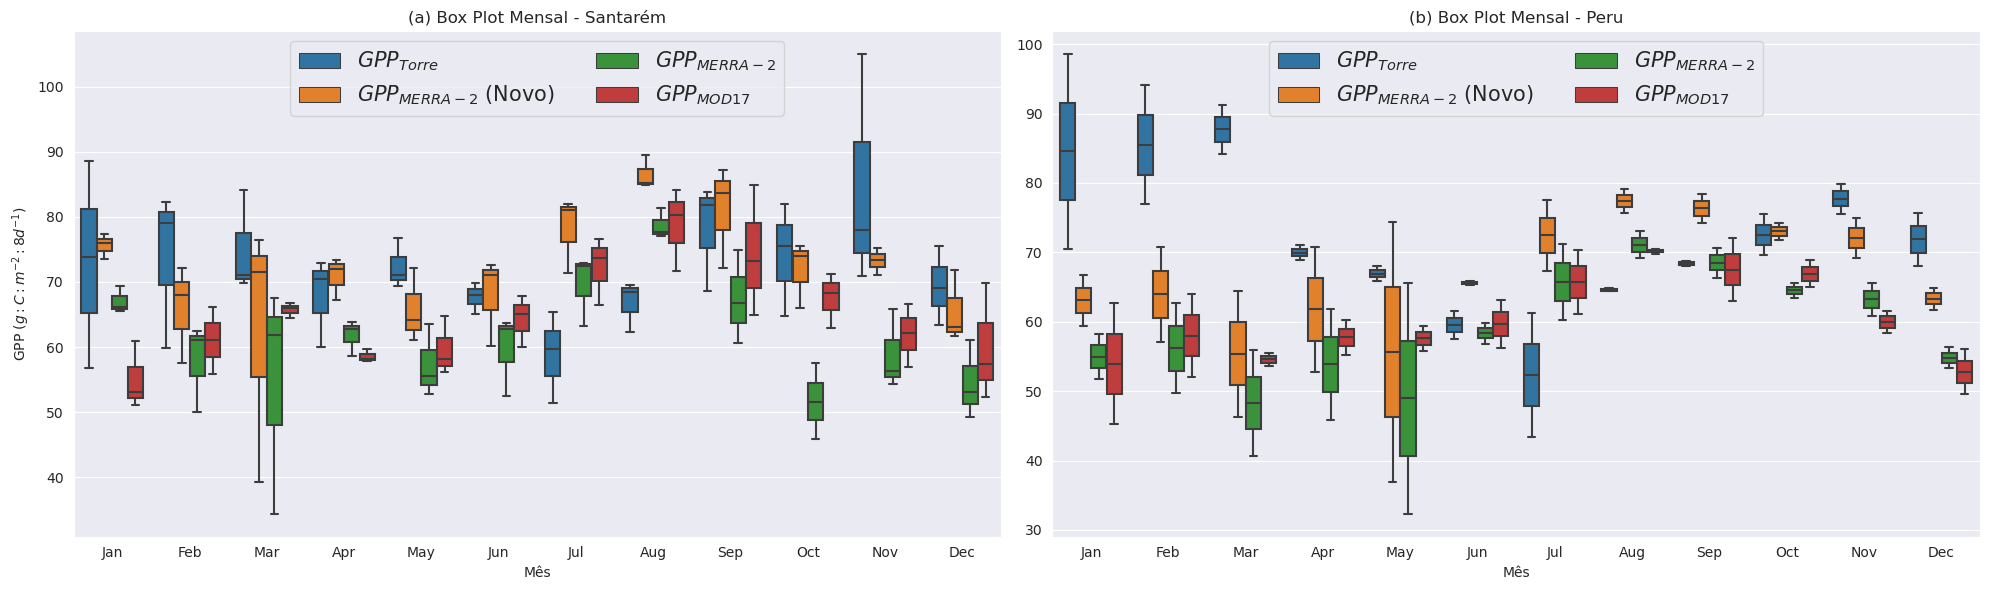

In [24]:
# Definindo os dados mensais de Santarém
observacoes_santarem_monthly = observacoes_santarem.resample('M').mean()
new_params_santarem_monthly = new_params_santarem.resample('M').mean()
santarem_gpp_mod_monthly = santarem_gpp_mod.resample('M').mean()
smoothed_gpp_algpad_santarem_monthly = smoothed_gpp_algpad_santarem.resample('M').mean()

# Criando DataFrame para Santarém com os dados resampleados
df_santarem = pd.DataFrame({
    '$GPP_{Torre}$': observacoes_santarem_monthly,
    '$GPP_{MERRA-2}$ (Novo)': new_params_santarem_monthly,
    '$GPP_{MERRA-2}$': smoothed_gpp_algpad_santarem_monthly,
    '$GPP_{MOD17}$': santarem_gpp_mod_monthly,
})

# Resetando o índice para ter uma coluna de datas
df_santarem.reset_index(inplace=True)

# Derretendo o DataFrame para ter todas as variáveis em uma única coluna
df_santarem_melted = df_santarem.melt(id_vars='index', var_name='Medição de GPP', value_name='Valor')

# Obtendo o ano e o mês de cada data
df_santarem_melted['Ano'] = df_santarem_melted['index'].dt.year
df_santarem_melted['Mes'] = df_santarem_melted['index'].dt.strftime('%b')


# Definindo os dados mensais de Peru
observacoes_peru_monthly = observacoes_peru.resample('M').mean()
new_params_peru_monthly = new_params_peru.resample('M').mean()
peru_gpp_mod_monthly = peru_gpp_mod.resample('M').mean()
smoothed_gpp_algpad_peru_monthly = smoothed_gpp_algpad_peru.resample('M').mean()

# Criando DataFrame para Peru com os dados resampleados
df_peru = pd.DataFrame({
    '$GPP_{Torre}$': observacoes_peru_monthly,
    '$GPP_{MERRA-2}$ (Novo)': new_params_peru_monthly,
    '$GPP_{MERRA-2}$': smoothed_gpp_algpad_peru_monthly,
    '$GPP_{MOD17}$': peru_gpp_mod_monthly
})

# Resetando o índice para ter uma coluna de datas
df_peru.reset_index(inplace=True)

# Derretendo o DataFrame para ter todas as variáveis em uma única coluna
df_peru_melted = df_peru.melt(id_vars='index', var_name='Medição de GPP', value_name='Valor')

# Obtendo o ano e o mês de cada data
df_peru_melted['Ano'] = df_peru_melted['index'].dt.year
df_peru_melted['Mes'] = df_peru_melted['index'].dt.strftime('%b')


# Plotando os boxplots em subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # Criando subplots com 2 linhas e 1 coluna

# Boxplot para Santarém
sns.boxplot(data=df_santarem_melted, x='Mes', y='Valor', hue='Medição de GPP', dodge=True, ax=axes[0])
axes[0].set_title('(a) Box Plot Mensal - Santarém')  # Definindo título
axes[0].set_ylabel('GPP ($g : C : m^{-2} : 8d^{-1}$)')  # Definindo rótulo do eixo y
axes[0].set_xlabel('Mês')  # Definindo rótulo do eixo x
axes[0].legend(loc='upper center', fontsize=15, ncol=2)  # Definindo legenda

# Boxplot para Peru
sns.boxplot(data=df_peru_melted, x='Mes', y='Valor', hue='Medição de GPP', dodge=True, ax=axes[1])
axes[1].set_title('(b) Box Plot Mensal - Peru')  # Definindo título
axes[1].set_ylabel('')  # Definindo rótulo do eixo y
axes[1].set_xlabel('Mês')  # Definindo rótulo do eixo x
axes[1].legend(loc='upper center', fontsize=15, ncol=2)  # Definindo legenda

plt.tight_layout()  # Ajustando layout
plt.savefig('imgs/BoxPlot_Santarem_Peru_PosOti.png', dpi=300, bbox_inches='tight', pad_inches=0.2)  # Salvando figura
plt.show()

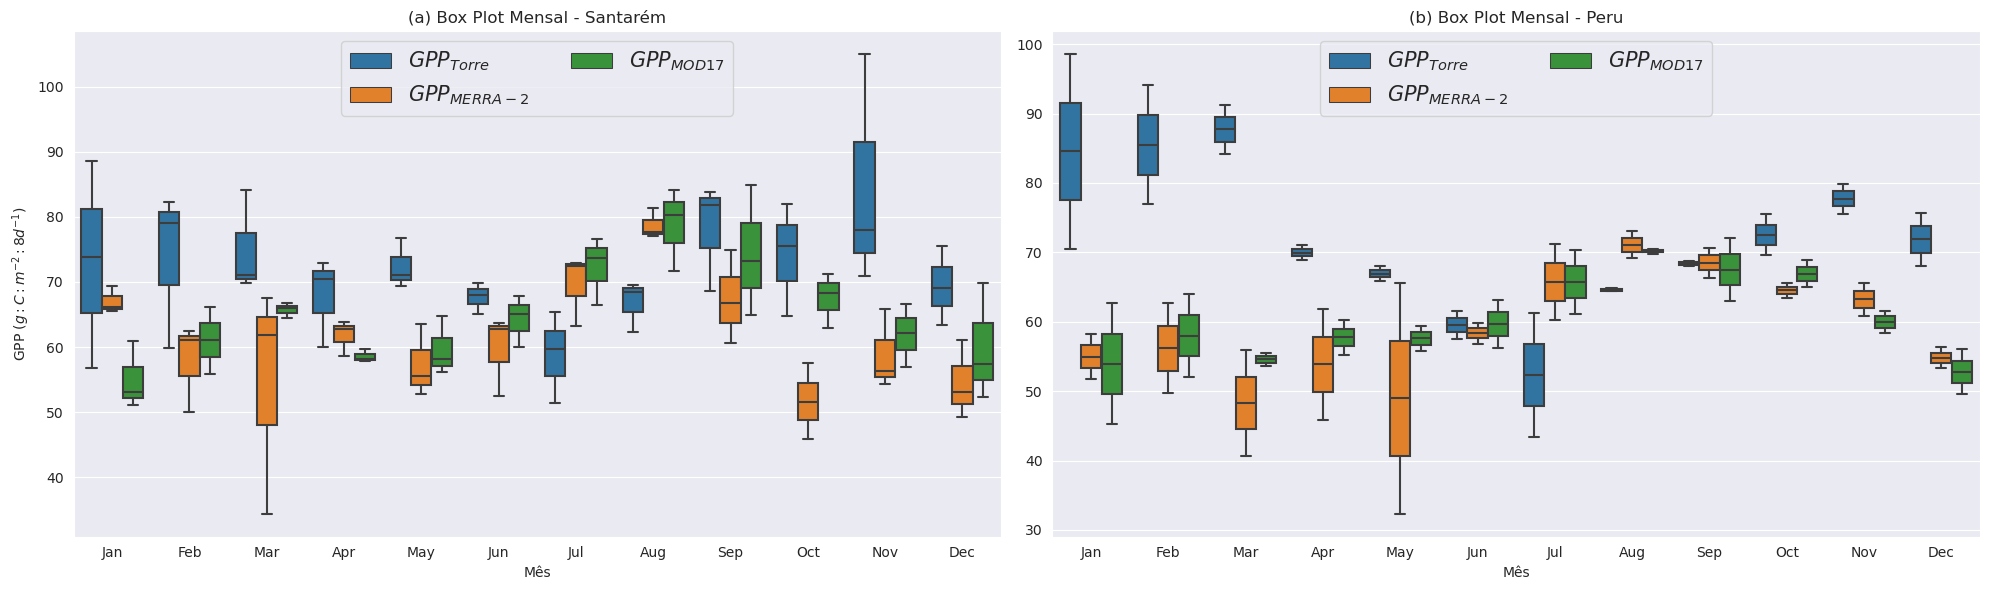

In [25]:
# Derretendo o DataFrame para ter todas as variáveis em uma única colun
df_santarem_melted = df_santarem.drop(['$GPP_{MERRA-2}$ (Novo)'],axis=1).melt(id_vars='index', var_name='Medição de GPP', value_name='Valor')

# Obtendo o ano e o mês de cada data
df_santarem_melted['Ano'] = df_santarem_melted['index'].dt.year
df_santarem_melted['Mes'] = df_santarem_melted['index'].dt.strftime('%b')


# Derretendo o DataFrame para ter todas as variáveis em uma única coluna
df_peru_melted = df_peru.drop(['$GPP_{MERRA-2}$ (Novo)'],axis=1).melt(id_vars='index', var_name='Medição de GPP', value_name='Valor')

# Obtendo o ano e o mês de cada data
df_peru_melted['Ano'] = df_peru_melted['index'].dt.year
df_peru_melted['Mes'] = df_peru_melted['index'].dt.strftime('%b')

# Plotando os boxplots em subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # Criando subplots com 2 linhas e 1 coluna

# Boxplot para Santarém
sns.boxplot(data=df_santarem_melted, x='Mes', y='Valor', hue='Medição de GPP', dodge=True, ax=axes[0])
axes[0].set_title('(a) Box Plot Mensal - Santarém')  # Definindo título
axes[0].set_ylabel('GPP ($g : C : m^{-2} : 8d^{-1}$)')  # Definindo rótulo do eixo y
axes[0].set_xlabel('Mês')  # Definindo rótulo do eixo x
axes[0].legend(loc='upper center', fontsize=15, ncol=2)  # Definindo legenda

# Boxplot para Peru
sns.boxplot(data=df_peru_melted, x='Mes', y='Valor', hue='Medição de GPP', dodge=True, ax=axes[1])
axes[1].set_title('(b) Box Plot Mensal - Peru')  # Definindo título
axes[1].set_ylabel('')  # Definindo rótulo do eixo y
axes[1].set_xlabel('Mês')  # Definindo rótulo do eixo x
axes[1].legend(loc='upper center', fontsize=15, ncol=2)  # Definindo legenda

plt.tight_layout()  # Ajustando layout
plt.savefig('imgs/BoxPlot_Santarem_Peru.png', dpi=300, bbox_inches='tight', pad_inches=0.2)  # Salvando figura
plt.show()

## Análise do NPP

### Cálculo do NPP (Peru)

In [26]:
index_santarem = pd.date_range(start='2009-01-01', end='2011-12-31', freq='D')
index_peru = pd.date_range(start='2018-01-01', end='2019-12-31', freq='D')

# Leitura e pré-processamento dos dados de NPP (kgC/m²/year)
npp_mod = pd.read_csv('mod_peru/filtered_scaled_Npp_500m.csv', header=None,na_values='F')
npp_mod.index = npp_mod[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
npp_mod = npp_mod.drop([0,1,2,3,4], axis=1)
npp_mod.columns = range(len(npp_mod.columns))
npp_modis_peru = npp_mod[144]


am_D = pd.read_csv('amf_pe/AMF_PE-QFR_FLUXNET_FULLSET_DD_2018-2019_3-5.csv',na_values=-9999) # Dados da torre pro mesmo dia
am_D.index = am_D['TIMESTAMP'].apply(lambda x:datetime.strptime(str(x), '%Y%m%d'))
#print([column for column in am_D.columns if 'NEE' in column])
temp_2 = am_D[['NEE_VUT_MEAN','RECO_DT_VUT_MEAN']].copy()
nep = -temp_2['NEE_VUT_MEAN'].copy()
reco = temp_2['RECO_DT_VUT_MEAN'].copy()
npp_peru = (nep + (0.3919 * reco)).resample('Y').sum() # Cálculo do NPP para eddy covariance

# Leitura e pré-processamento dos dados de LAI
lai_peru = pd.read_csv('mod_peru/filtered_scaled_Lai_500m.csv', header=None,na_values='F') # unidade: m²/m²
lai_peru.index = lai_peru[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
lai_peru = lai_peru.drop([0,1,2,3,4], axis=1)
lai_peru.columns = range(len(lai_peru.columns))
lai_peru = lai_peru[144]

# ================================

lai_peru = lai_peru.resample('D').interpolate('linear')['2018 ':'2019']


npp_algoritmo_peru = MOD17._npp(params=(melhor_params + list(parametros_padrao)[5:]),fpar=drivers_peru[0],tmin=drivers_peru[1],vpd=drivers_peru[2],par=drivers_peru[3],tmean=tmean_peru[:][...,None],years=index_peru.year.values[:][...,None],lai=lai_peru.values[:][...,None])
npp_algoritmopad_peru = MOD17._npp(params=parametros_padrao,fpar=drivers_peru[0],tmin=drivers_peru[1],vpd=drivers_peru[2],par=drivers_peru[3],tmean=tmean_peru[:][...,None],years=index_peru.year.values[:][...,None],lai=lai_peru.values[:][...,None])

### Cálculo do NPP (Santarém)

In [27]:
# Leitura e pré-processamento dos dados de NPP (kgC/m²/year)
npp_mod = pd.read_csv('santarem_mod/filtered_scaled_Npp_500m.csv', header=None,na_values='F')
npp_mod.index = npp_mod[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
npp_mod = npp_mod.drop([0,1,2,3,4], axis=1)
npp_mod.columns = range(len(npp_mod.columns))
npp_modis = npp_mod[144]
npp_modis_st = npp_modis[['2009-01-01','2010-01-01','2011-01-01']]

ameriflux = pd.read_csv('./santarem_torre/ameriflux-santarem-dados-original.csv',na_values=-9999) # Dados da AMERIFLUX
ameriflux.loc[0, 'Time'] = '00:00:00'
ameriflux.index = pd.to_datetime(ameriflux['Date'] + ' ' + ameriflux['Time'], format='%Y-%m-%d %H:%M:%S')

nee = ameriflux['NEE_uStar_f'].copy()
reco = ameriflux['Reco_uStar'].copy()
gpp = ameriflux['GPP_uStar_f'].copy()

nee_kgc = nee.apply(to_kgC)
reco_kgc_total = reco.apply(to_kgC)
npp_santarem = (-nee_kgc + (0.3919 * reco_kgc_total)).resample('Y').sum()

# Leitura e pré-processamento dos dados de LAI
lai_santarem = pd.read_csv('santarem_mod/filtered_scaled_Lai_500m.csv', header=None,na_values='F') # unidade: m²/m²
lai_santarem.index = lai_santarem[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
lai_santarem = lai_santarem.drop([0,1,2,3,4], axis=1)
lai_santarem.columns = range(len(lai_santarem.columns))
lai_santarem = lai_santarem[144]

# ================================

lai_santarem = lai_santarem.resample('D').interpolate('linear')['2009-01-01':'2011-12-31']

npp_algoritmo_st = MOD17._npp(params=(melhor_params + list(parametros_padrao)[5:]),fpar=drivers_santarem[0],tmin=drivers_santarem[1],vpd=drivers_santarem[2],par=drivers_santarem[3],tmean=tmean_santarem[:][...,None],years=index_santarem.year.values[:][...,None],lai=lai_santarem.values[:][...,None])
npp_algoritmopad_st = MOD17._npp(params=parametros_padrao,fpar=drivers_santarem[0],tmin=drivers_santarem[1],vpd=drivers_santarem[2],par=drivers_santarem[3],tmean=tmean_santarem[:][...,None],years=index_santarem.year.values[:][...,None],lai=lai_santarem.values[:][...,None])

### Resultados

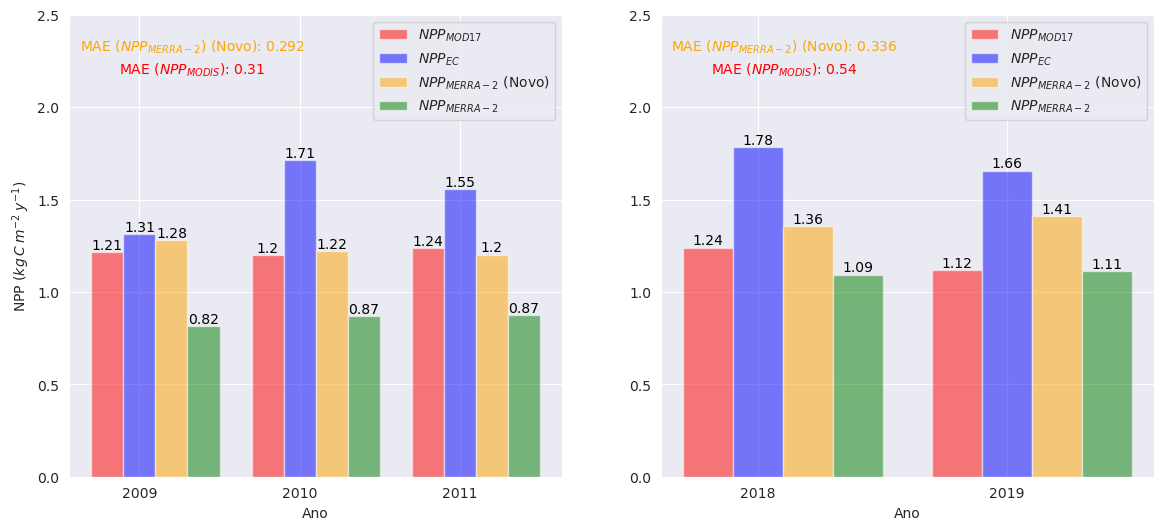

In [29]:
# Defina a largura das barras
largura_barra = 0.2

# Obter uma lista de anos únicos presentes nos dados
anos_unicos_peru = observacoes_peru.index.year.unique()
anos_unicos_santarem = observacoes_santarem.index.year.unique()

# Convertendo os anos em formato de string
anos_unicos_str_peru = [str(ano) for ano in anos_unicos_peru]
anos_unicos_str_santarem = [str(ano) for ano in anos_unicos_santarem]

# Defina os deslocamentos das barras para os diferentes conjuntos de dados
deslocamento_peru = np.arange(len(anos_unicos_peru))
deslocamento_santarem = np.arange(len(anos_unicos_santarem))

# Criação da figura e dos subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))


# Plotando as barras agrupadas para cada conjunto de dados (Santarem)
axs[0].bar(deslocamento_santarem - largura_barra, npp_modis_st.values, width=largura_barra, color='red', alpha=0.5, label='$NPP_{MOD17}$')
axs[0].bar(deslocamento_santarem, npp_santarem, width=largura_barra, color='blue', alpha=0.5, label='$NPP_{EC}$')
axs[0].bar(deslocamento_santarem + largura_barra, (npp_algoritmo_st / 1000).reshape(3), width=largura_barra, color='orange', alpha=0.5, label='$NPP_{MERRA-2}$ (Novo)')
axs[0].bar(deslocamento_santarem + 2*largura_barra, (npp_algoritmopad_st / 1000).reshape(3), width=largura_barra, color='green', alpha=0.5, label='$NPP_{MERRA-2}$')
axs[0].set_ylabel('NPP ($kg \: C \: m^{-2} \: y^{-1}$)')

# Plotando as barras agrupadas para cada conjunto de dados (Peru)
axs[1].bar(deslocamento_peru - largura_barra, npp_modis_peru['2018':'2019'].values, width=largura_barra, color='red', alpha=0.5, label='$NPP_{MOD17}$')
axs[1].bar(deslocamento_peru, npp_peru / 1000, width=largura_barra, color='blue', alpha=0.5, label='$NPP_{EC}$')
axs[1].bar(deslocamento_peru + largura_barra, (npp_algoritmo_peru / 1000).reshape(2), width=largura_barra, color='orange', alpha=0.5, label='$NPP_{MERRA-2}$ (Novo)')
axs[1].bar(deslocamento_peru + 2*(largura_barra), (npp_algoritmopad_peru / 1000).reshape(2), width=largura_barra, color='green', alpha=0.5, label='$NPP_{MERRA-2}$')

for i, valor in enumerate(npp_modis_peru['2018':'2019'].values):
    axs[1].text(i - largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_peru / 1000)):
    axs[1].text(i, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_algoritmo_peru / 1000).reshape(2)):
    axs[1].text(i + largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_algoritmopad_peru / 1000).reshape(2)):
    axs[1].text(i + 2*(largura_barra), valor, str(round(valor, 2)), ha='center', va='bottom', color='black')

# Adicionando legendas e rótulos (Peru)
axs[1].legend()
axs[1].set_ylim(top=2.5)
axs[1].set_xlabel('Ano')
axs[1].set_xticks(deslocamento_peru)
axs[1].set_xticklabels(anos_unicos_str_peru)


mae_peru = mean_absolute_error(npp_peru / 1000, npp_algoritmo_peru / 1000)

mae_santarem = mean_absolute_error(npp_santarem, npp_algoritmo_st / 1000)

mae_pad_peru = mean_absolute_error(npp_peru / 1000, npp_algoritmopad_peru / 1000)

mae_pad_santarem = mean_absolute_error(npp_santarem, npp_algoritmopad_st / 1000)

mae_modis_peru = mean_absolute_error(npp_peru / 1000, npp_modis_peru['2018':'2019'].values)

mae_modis_santarem = mean_absolute_error(npp_santarem, npp_modis_st.values)

axs[1].text(0.25, 0.9, 'MAE ($NPP_{MODIS}$):' + ' ' + f'{mae_modis_peru:.2f}', ha='center', va='top', transform=axs[1].transAxes, fontsize=10, color='red')
axs[0].text(0.25, 0.9, 'MAE ($NPP_{MODIS}$):' + ' ' + f'{mae_modis_santarem:.2f}', ha='center', va='top', transform=axs[0].transAxes, fontsize=10, color='red')


axs[1].text(0.25, 0.95, 'MAE ($NPP_{MERRA-2}$) (Novo):' + ' ' + f'{mae_peru:.3f}', ha='center', va='top', transform=axs[1].transAxes, fontsize=10, color='orange')
axs[0].text(0.25, 0.95, 'MAE ($NPP_{MERRA-2}$) (Novo):' + ' ' + f'{mae_santarem:.3f}', ha='center', va='top', transform=axs[0].transAxes, fontsize=10, color='orange')

for i, valor in enumerate(npp_modis_st.values):
    axs[0].text(i - largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_santarem)):
    axs[0].text(i, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_algoritmo_st / 1000).reshape(3)):
    axs[0].text(i + largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_algoritmopad_st / 1000).reshape(3)):
    axs[0].text(i + 2*largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')

# Adicionando legendas e rótulos (Santarem)
axs[0].legend()
axs[0].set_ylim(top=2.5)
axs[0].set_xlabel('Ano')

axs[0].set_xticks(deslocamento_santarem)
axs[0].set_xticklabels(anos_unicos_str_santarem)

plt.savefig('imgs/npp_otimizado.png')
plt.show()

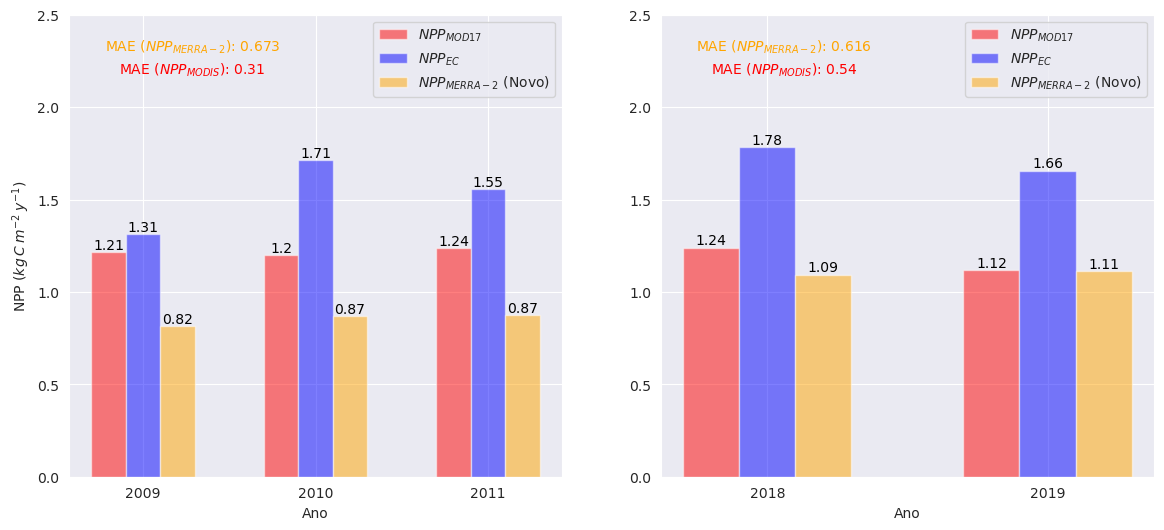

In [30]:
# Criação da figura e dos subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))


# Plotando as barras agrupadas para cada conjunto de dados (Santarem)
axs[0].bar(deslocamento_santarem - largura_barra, npp_modis_st.values, width=largura_barra, color='red', alpha=0.5, label='$NPP_{MOD17}$')
axs[0].bar(deslocamento_santarem, npp_santarem, width=largura_barra, color='blue', alpha=0.5, label='$NPP_{EC}$')
axs[0].bar(deslocamento_santarem + largura_barra, (npp_algoritmopad_st / 1000).reshape(3), width=largura_barra, color='orange', alpha=0.5, label='$NPP_{MERRA-2}$ (Novo)')
axs[0].set_ylabel('NPP ($kg \: C \: m^{-2} \: y^{-1}$)')

# Plotando as barras agrupadas para cada conjunto de dados (Peru)
axs[1].bar(deslocamento_peru - largura_barra, npp_modis_peru['2018':'2019'].values, width=largura_barra, color='red', alpha=0.5, label='$NPP_{MOD17}$')
axs[1].bar(deslocamento_peru, npp_peru / 1000, width=largura_barra, color='blue', alpha=0.5, label='$NPP_{EC}$')
axs[1].bar(deslocamento_peru + largura_barra, (npp_algoritmopad_peru / 1000).reshape(2), width=largura_barra, color='orange', alpha=0.5, label='$NPP_{MERRA-2}$ (Novo)')

for i, valor in enumerate(npp_modis_peru['2018':'2019'].values):
    axs[1].text(i - largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_peru / 1000)):
    axs[1].text(i, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_algoritmopad_peru / 1000).reshape(2)):
    axs[1].text(i + largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')

# Adicionando legendas e rótulos (Peru)
axs[1].legend()
axs[1].set_ylim(top=2.5)
axs[1].set_xlabel('Ano')
axs[1].set_xticks(deslocamento_peru)
axs[1].set_xticklabels(anos_unicos_str_peru)

axs[1].text(0.25, 0.9, 'MAE ($NPP_{MODIS}$):' + ' ' + f'{mae_modis_peru:.2f}', ha='center', va='top', transform=axs[1].transAxes, fontsize=10, color='red')
axs[0].text(0.25, 0.9, 'MAE ($NPP_{MODIS}$):' + ' ' + f'{mae_modis_santarem:.2f}', ha='center', va='top', transform=axs[0].transAxes, fontsize=10, color='red')


axs[1].text(0.25, 0.95, 'MAE ($NPP_{MERRA-2}$):' + ' ' + f'{mae_pad_peru:.3f}', ha='center', va='top', transform=axs[1].transAxes, fontsize=10, color='orange')
axs[0].text(0.25, 0.95, 'MAE ($NPP_{MERRA-2}$):' + ' ' + f'{mae_pad_santarem:.3f}', ha='center', va='top', transform=axs[0].transAxes, fontsize=10, color='orange')

for i, valor in enumerate(npp_modis_st.values):
    axs[0].text(i - largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_santarem)):
    axs[0].text(i, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')
for i, valor in enumerate((npp_algoritmopad_st / 1000).reshape(3)):
    axs[0].text(i + largura_barra, valor, str(round(valor, 2)), ha='center', va='bottom', color='black')

# Adicionando legendas e rótulos (Santarem)
axs[0].legend()
axs[0].set_ylim(top=2.5)
axs[0].set_xlabel('Ano')

axs[0].set_xticks(deslocamento_santarem)
axs[0].set_xticklabels(anos_unicos_str_santarem)

plt.savefig('imgs/npp_original.png')
plt.show()